# Notebook de découverte des personas  
## Adrian Rodriguez   
## Projet 3 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Segmentez-des-clients-d-un-site-e-commerce-Formation-IML   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte


Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

L'objectif de ce notebook est d'en apprendre un peu plus sur les personas des clients Olist, après segmentation.

Il pourra être approfondi et/ou réorienté en fonction d'une éventuelle demande du client.

---
# 1. Importation et exploration préliminaire

In [1]:
import pandas as pd

import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly

from functions import *

pd.options.display.max_columns = None
plt.style.use("default")

In [2]:
# Pour vérifier le respect de la convention PEP8
# Installation conda non diponible. Utiliser pip
%load_ext pycodestyle_magic
%pycodestyle_on

In [3]:
persona_raw = pd.read_csv('src/persona.csv')

In [4]:
persona_raw.shape

(93791, 18)

In [5]:
persona_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93791 entries, 0 to 93790
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    93791 non-null  object 
 1   frequency             93791 non-null  int64  
 2   recency               93791 non-null  int64  
 3   delivery_respect      93791 non-null  int64  
 4   n_item                93791 non-null  float64
 5   main_category_fr      93791 non-null  object 
 6   n_photos_class        93791 non-null  float64
 7   len_desc_class        93791 non-null  float64
 8   ratio_freight_amount  93791 non-null  float64
 9   prefered_payment      93791 non-null  object 
 10  monetary_value        93791 non-null  float64
 11  review_score          93791 non-null  int64  
 12  R                     93791 non-null  int64  
 13  F                     93791 non-null  int64  
 14  M                     93791 non-null  int64  
 15  RFM_Segment        

In [6]:
persona_raw.columns

Index(['customer_unique_id', 'frequency', 'recency', 'delivery_respect',
       'n_item', 'main_category_fr', 'n_photos_class', 'len_desc_class',
       'ratio_freight_amount', 'prefered_payment', 'monetary_value',
       'review_score', 'R', 'F', 'M', 'RFM_Segment', 'RFM_Score',
       'cluster_name'],
      dtype='object')

In [7]:
persona_raw.dtypes

customer_unique_id       object
frequency                 int64
recency                   int64
delivery_respect          int64
n_item                  float64
main_category_fr         object
n_photos_class          float64
len_desc_class          float64
ratio_freight_amount    float64
prefered_payment         object
monetary_value          float64
review_score              int64
R                         int64
F                         int64
M                         int64
RFM_Segment               int64
RFM_Score               float64
cluster_name             object
dtype: object

In [9]:
persona_raw.head()

,customer_unique_id,frequency,recency,delivery_respect,n_item,main_category_fr,n_photos_class,len_desc_class,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M,RFM_Segment,RFM_Score,cluster_name
0,0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,Meuble Déco,1.0,1.0,8.46,credit_card,141.90,5,4,1,3,413,8.0,1.Top client
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,Mode Bagage,1.0,3.0,30.49,credit_card,27.19,4,4,1,1,411,6.0,4.Client à faible valeur
2,0000f46a3911fa3c0805444483337064,1,543,2,1.0,Librairie,2.0,1.0,19.97,credit_card,86.22,3,1,1,2,112,4.0,6.Client mécontent
3,0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,Téléphonie,3.0,4.0,40.42,credit_card,43.62,4,2,1,1,211,4.0,4.Client à faible valeur
4,0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,Téléphonie,2.0,3.0,8.58,credit_card,196.89,5,2,1,4,214,7.0,1.Top client


In [10]:
persona = persona_raw.copy()

# 2. Analyse des personas
# 2-1. Catégories des ventes

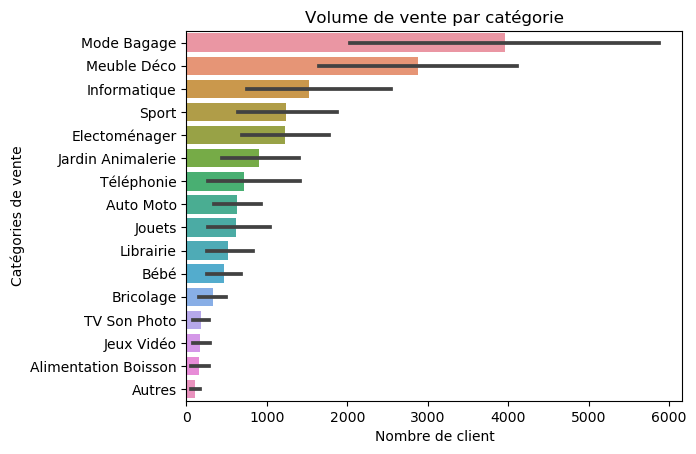

In [11]:
# Je classe les catégories par ordre d'importance
category = persona.groupby('main_category_fr')['customer_unique_id']\
                            .count()
order = category.sort_values(ascending=False).index.to_list()

# Je groupe par produit et par cluster
group = ['main_category_fr', 'cluster_name']
customer_cat = persona.groupby(group)['customer_unique_id']\
                                .count().reset_index()

plt.clf()
sns.barplot(y='main_category_fr',
            x='customer_unique_id',
            data=customer_cat,
            order=order,
            orient='h')
plt.title('Volume de vente par catégorie')
plt.xlabel('Nombre de client')
plt.ylabel('Catégories de vente')

plt.savefig('img/img_cat_customers.png',
            transparent=True,
            bbox_inches="tight")

Les ventes sont dominées par les catégories "Mode Bagages" et "Meuble Déco".

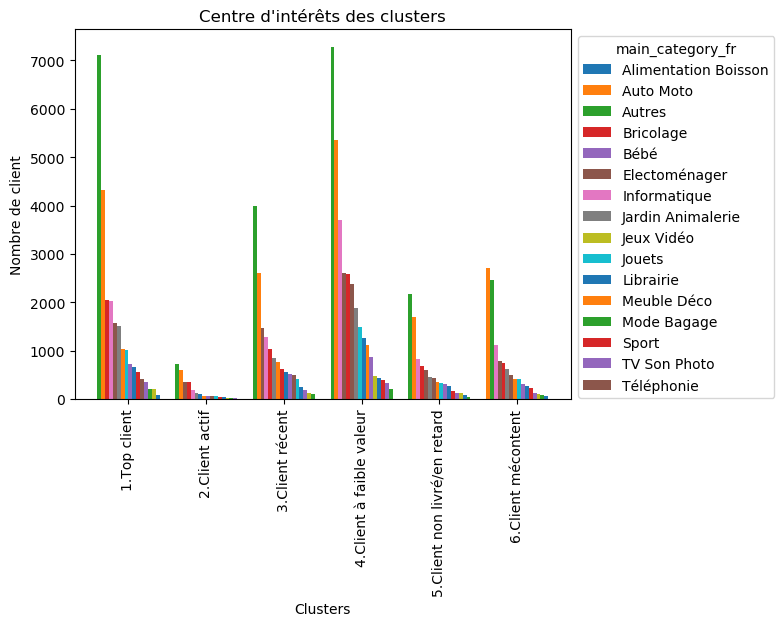

In [12]:
# Je groupe par produit et par cluster
group = ['main_category_fr', 'cluster_name']
customer_cat = persona.groupby(group)['customer_unique_id']\
                                .count().reset_index()

fig, ax = plt.subplots()
sortedgroupedbar(ax,
                 x="cluster_name",
                 y="customer_unique_id",
                 groupby="main_category_fr",
                 data=customer_cat,
                 legend_anchor=(1, 1))

plt.title("Centre d'intérêts des clusters")
plt.xlabel('Clusters')
plt.ylabel('Nombre de client')
plt.xticks(rotation=90)
plt.savefig('img/img_cat_customers_cluster.png',
            transparent=True,
            bbox_inches="tight")

La catégorie "Mode Bagage" occupe une place prédominante dans les 3 premières catégories. La catégorie informatique occupe un place intéressante dans le cluster des clients récents. Peut-être une ouverture de marché ?

## 4-2. Informations relatives à la commande

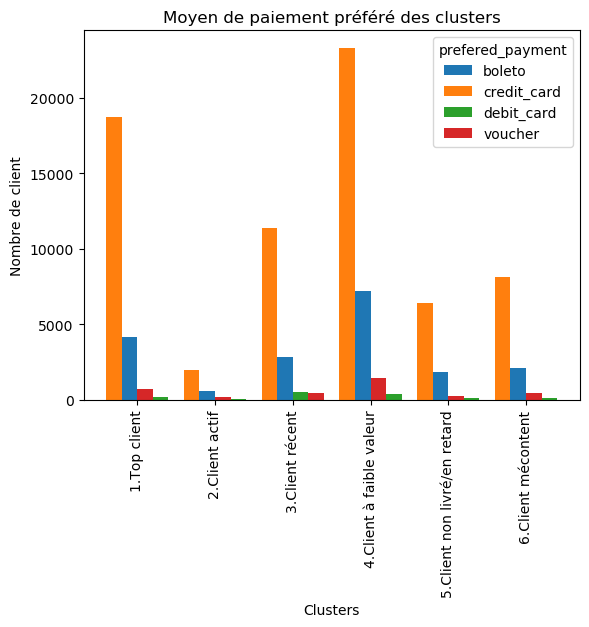

In [13]:
group = ['prefered_payment', 'cluster_name']
customer_payment = persona.groupby(group)['customer_unique_id']\
                                    .count().reset_index()

fig, ax = plt.subplots()
sortedgroupedbar(ax,
                 x="cluster_name",
                 y="customer_unique_id",
                 groupby="prefered_payment",
                 data=customer_payment)

plt.title("Moyen de paiement préféré des clusters")
plt.xlabel('Clusters')
plt.ylabel('Nombre de client')
plt.xticks(rotation=90)
plt.savefig('img/img_payment_customers_cluster.png',
            transparent=True,
            bbox_inches="tight")

Il n'y a pas un cluster qui préfère un paiement plus qu'un autre

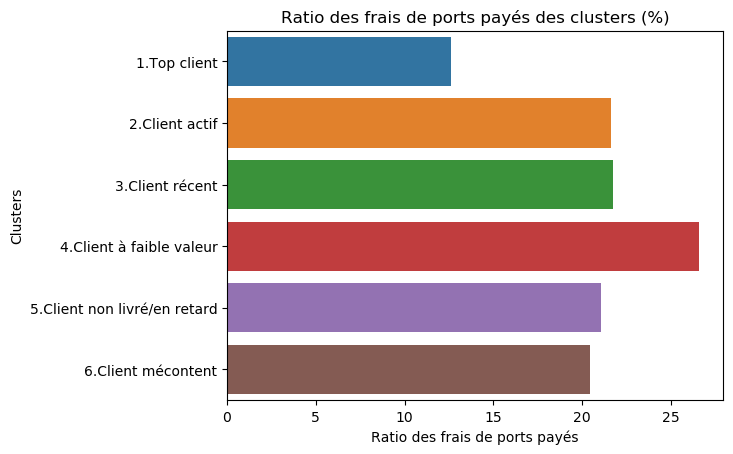

In [14]:
customer_freight = persona\
                    .groupby('cluster_name')['ratio_freight_amount']\
                    .mean().reset_index()

sns.barplot(y='cluster_name',
            x='ratio_freight_amount',
            data=customer_freight,
            orient='h')

plt.title("Ratio des frais de ports payés des clusters (%)")
plt.xlabel('Ratio des frais de ports payés')
plt.ylabel('Clusters')
plt.savefig('img/img_freight_paid_cluster.png',
            transparent=True,
            bbox_inches="tight")

Le top client paye peu de frais de port alors que le client récent en paye beaucoup.

## 4-3. Informations relatives à la fiche produit

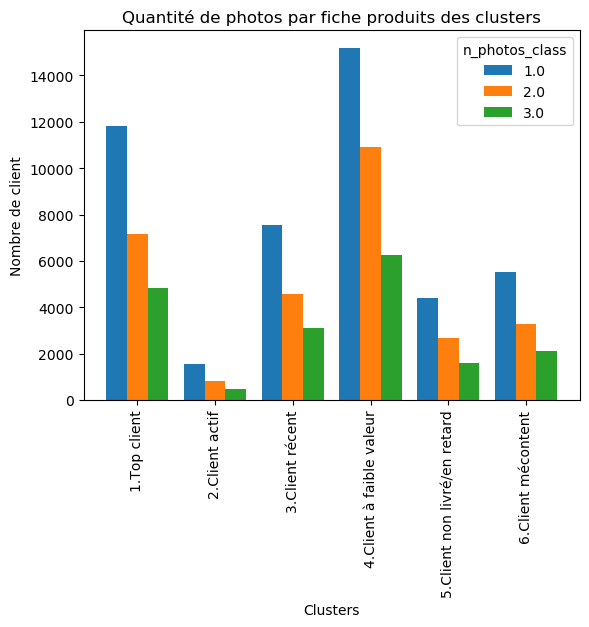

In [15]:
# Nombre de photos
group = ['n_photos_class', 'cluster_name']
customer_photos = persona.groupby(group)['customer_unique_id']\
                                   .count().reset_index()

fig, ax = plt.subplots()
sortedgroupedbar(ax,
                 x="cluster_name",
                 y="customer_unique_id",
                 groupby="n_photos_class",
                 data=customer_photos)

plt.title("Quantité de photos par fiche produits des clusters")
plt.xlabel('Clusters')
plt.ylabel('Nombre de client')
plt.xticks(rotation=90)
plt.savefig('img/img_review_customers_cluster.png',
            transparent=True,
            bbox_inches="tight")

La quantité de photos présentes sur une fiche produit n'influence pas un cluster plus que l'autre

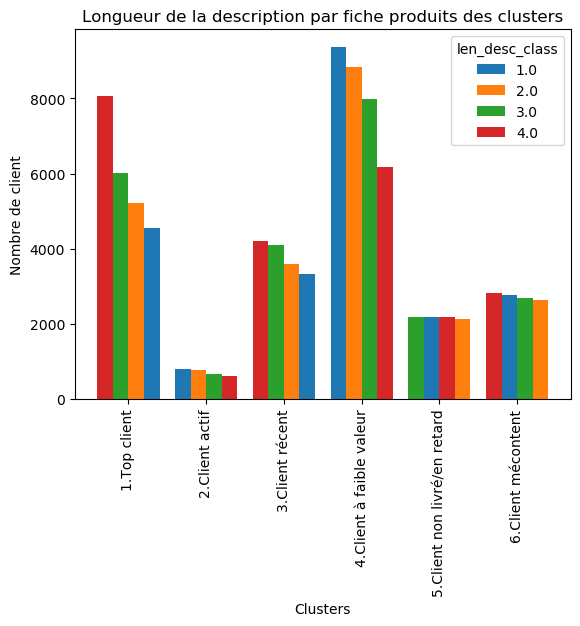

In [16]:
# Longueur de la description
group = ['len_desc_class', 'cluster_name']
customer_description = persona.groupby(group)['customer_unique_id']\
                                        .count().reset_index()

fig, ax = plt.subplots()
sortedgroupedbar(ax,
                 x="cluster_name",
                 y="customer_unique_id",
                 groupby="len_desc_class",
                 data=customer_description)

plt.title("Longueur de la description par fiche produits des clusters")
plt.xlabel('Clusters')
plt.ylabel('Nombre de client')
plt.xticks(rotation=90)
plt.savefig('img/img_review_customers_cluster.png',
            transparent=True,
            bbox_inches="tight")

Le top client aime les descriptions bien remplies

## 4-4. Situation du score RFM dans la segmentation non supervisée.

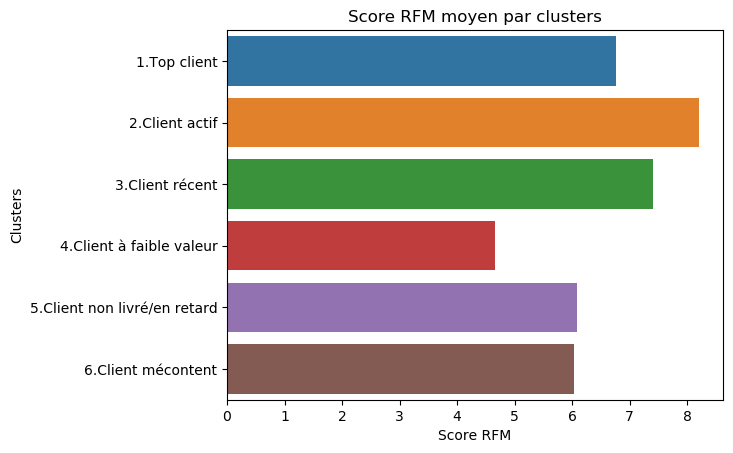

In [17]:
customer_RFM_Score = persona\
                    .groupby('cluster_name')['RFM_Score']\
                    .mean().reset_index()

sns.barplot(y='cluster_name',
            x='RFM_Score',
            data=customer_RFM_Score,
            orient='h')

plt.title("Score RFM moyen par clusters")
plt.xlabel('Score RFM')
plt.ylabel('Clusters')

plt.savefig('img/img_RFM_score_cluster.png',
            transparent=True,
            bbox_inches="tight")

Le client actif est mieux placé avec une segmentation RFM que le top client.